<a href="https://colab.research.google.com/github/rohitkhadka1/FxPy/blob/main/hybrid_trading_strategy_rnn_rsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Import libraries and setup
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [21]:
class TradingAlgorithm:
    def __init__(self, symbol='SPY', start_date='2010-01-01', end_date='2024-09-01', initial_cash=100000):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.position = 0
        self.portfolio_value = []
        self.trades = []

        # Technical indicators parameters
        self.rsi_period = 2
        self.ma9_period = 9
        self.ma200_period = 200

        # RNN parameters
        self.lookback = 10
        self.feature_count = 2
        self.hidden_size = 64
        self.learning_rate = 0.01
        self.rnn_threshold = 0.001
        self.position_size = 0.8

        # RNN weights
        self.scaler = StandardScaler()
        self.scaler_fitted = False

        print(f"Initialized trading algorithm for {symbol}")
        print(f"Period: {start_date} to {end_date}")
        print(f"Initial cash: ${initial_cash:,}")

    def download_data(self):
        """Download stock data using yfinance"""
        print("Downloading data...")

        # Download training data (2000-2009)
        train_start = '2000-01-01'
        train_end = '2009-12-31'
        self.train_data = yf.download(self.symbol, start=train_start, end=train_end)

        # Download trading data
        self.data = yf.download(self.symbol, start=self.start_date, end=self.end_date)

        print(f"Downloaded {len(self.train_data)} training samples")
        print(f"Downloaded {len(self.data)} trading samples")

        # Calculate technical indicators
        self.calculate_indicators()

    def calculate_indicators(self):
        """Calculate RSI and moving averages"""
        # RSI calculation
        def calculate_rsi(prices, period=2):
            delta = prices.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
            rs = gain / loss
            rsi = 100 - (100 / (1 + rs))
            return rsi

        # For trading data - fix pandas Series operations
        close_prices = self.data['Close'].values
        self.data['RSI'] = calculate_rsi(self.data['Close'], self.rsi_period)
        self.data['MA9'] = self.data['Close'].rolling(window=self.ma9_period).mean()
        self.data['MA200'] = self.data['Close'].rolling(window=self.ma200_period).mean()

        # For training data
        self.train_data['RSI'] = calculate_rsi(self.train_data['Close'], self.rsi_period)
        self.train_data['MA9'] = self.train_data['Close'].rolling(window=self.ma9_period).mean()
        self.train_data['MA200'] = self.train_data['Close'].rolling(window=self.ma200_period).mean()

        print("Technical indicators calculated")

    def initialize_rnn(self):
        """Initialize RNN weights"""
        np.random.seed(42)
        self.Wxh = np.random.randn(self.hidden_size, self.feature_count) * 0.01
        self.Whh = np.random.randn(self.hidden_size, self.hidden_size) * 0.01
        self.Why = np.random.randn(1, self.hidden_size) * 0.01
        self.bh = np.zeros((self.hidden_size, 1))
        self.by = np.zeros((1, 1))

        print("RNN initialized")

    def get_features_from_data(self, data_slice):
        """Extract features from data slice"""
        if len(data_slice) < 2:
            return None

        features = []
        for i in range(len(data_slice) - 1):
            current = data_slice.iloc[i]
            next_day = data_slice.iloc[i + 1]

            # Feature 1: Price change
            price_change = (next_day['Close'] - current['Close']) / current['Close']

            # Feature 2: Overnight gap
            overnight_gap = (next_day['Open'] - current['Close']) / current['Close']

            features.append([price_change, overnight_gap])

        return np.array(features)

    def forward(self, X):
        """Forward pass through RNN"""
        h = np.zeros((self.hidden_size, 1))
        hidden_states = [h.copy()]

        for x in X:
            h = np.tanh(np.dot(self.Wxh, x.reshape(-1, 1)) + np.dot(self.Whh, h) + self.bh)
            hidden_states.append(h.copy())

        y = np.dot(self.Why, h) + self.by
        return y, hidden_states

    def backward(self, X, hidden_states, y_true, y_pred):
        """Backpropagation through time"""
        dWhh = np.zeros_like(self.Whh)
        dWxh = np.zeros_like(self.Wxh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)

        # Output layer gradients
        dy = 2 * (y_pred - y_true)
        dWhy += np.dot(dy, hidden_states[-1].T)
        dby += dy

        # Hidden layer gradients
        dh = np.dot(self.Why.T, dy)

        # Backpropagate through time
        for t in reversed(range(len(X))):
            dh_raw = dh * (1 - hidden_states[t + 1] ** 2)
            dbh += dh_raw
            dWxh += np.dot(dh_raw, X[t].reshape(1, -1))
            if t > 0:
                dWhh += np.dot(dh_raw, hidden_states[t].T)
            dh = np.dot(self.Whh.T, dh_raw)

        # Update weights
        self.Whh -= self.learning_rate * dWhh
        self.Wxh -= self.learning_rate * dWxh
        self.Why -= self.learning_rate * dWhy
        self.bh -= self.learning_rate * dbh
        self.by -= self.learning_rate * dby

    def train_rnn(self):
        """Train the RNN on historical data"""
        print("Training RNN...")

        features = []
        targets = []

        for i in range(len(self.train_data) - self.lookback):
            feature = self.get_features_from_data(self.train_data.iloc[i:i + self.lookback + 1])
            if feature is not None and len(feature) == self.lookback:
                features.append(feature)
                # Target: next day's price change
                target = (self.train_data['Close'].iloc[i + self.lookback] -
                         self.train_data['Open'].iloc[i + self.lookback])
                targets.append(target)

        if len(features) == 0:
            print("No features extracted for training")
            return

        features = np.array(features)
        targets = np.array(targets).reshape(-1, 1)

        # Scale features
        features_flat = features.reshape(-1, features.shape[-1])
        features_scaled = self.scaler.fit_transform(features_flat).reshape(features.shape)
        self.scaler_fitted = True

        # Training loop
        epochs = 100
        losses = []

        for epoch in range(epochs):
            epoch_loss = 0
            for feature, target in zip(features_scaled, targets):
                prediction, hidden_states = self.forward(feature)
                loss = np.square(prediction - target).mean()
                epoch_loss += loss
                self.backward(feature, hidden_states, target, prediction)

            avg_loss = epoch_loss / len(features)
            losses.append(avg_loss)

            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

        print("RNN training completed")

        # Plot training loss
        plt.figure(figsize=(10, 6))
        plt.plot(losses)
        plt.title('RNN Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def get_prediction(self, current_data, index):
        """Get RNN prediction for current data"""
        if index < self.lookback:
            return 0.0

        try:
            # Get recent data
            start_idx = max(0, index - self.lookback)
            end_idx = index + 1
            recent_data = current_data.iloc[start_idx:end_idx]

            if len(recent_data) <= self.lookback:
                return 0.0

            features = self.get_features_from_data(recent_data)

            if features is None or len(features) == 0 or not self.scaler_fitted:
                return 0.0

            # Ensure features have correct shape
            if len(features) != self.lookback:
                return 0.0

            # Scale features
            features_scaled = self.scaler.transform(features)

            # Get prediction
            prediction, _ = self.forward(features_scaled)
            return float(prediction[0, 0])

        except Exception as e:
            return 0.0

    def run_backtest(self):
        """Run the trading backtest"""
        print("Running backtest...")

        portfolio_values = []
        positions = []
        predictions = []

        # Clean data and handle NaN values
        self.data = self.data.dropna()

        for i in range(len(self.data)):
            current_row = self.data.iloc[i]

            # Get prediction
            prediction = self.get_prediction(self.data, i)
            predictions.append(prediction)

            # Current values - ensure they are scalar values
            current_price = float(current_row['Close'])
            rsi_value = float(current_row['RSI']) if not pd.isna(current_row['RSI']) else 50.0
            ma200_value = float(current_row['MA200']) if not pd.isna(current_row['MA200']) else current_price

            # Trading signals - fix pandas Series boolean ambiguity
            long_condition = (
                rsi_value < 10 and
                current_price > ma200_value and
                prediction > self.rnn_threshold
            )

            short_condition = (
                rsi_value > 90 and
                current_price < ma200_value and
                prediction < -self.rnn_threshold
            )

            exit_long_condition = rsi_value > 50 or prediction < 0
            exit_short_condition = rsi_value < 50 or prediction > 0

            # Execute trades
            if long_condition and self.position <= 0:
                if self.position < 0:  # Close short position
                    self.cash += abs(self.position) * current_price
                    self.position = 0

                # Open long position
                shares_to_buy = int((self.cash * self.position_size) / current_price)
                self.position = shares_to_buy
                self.cash -= shares_to_buy * current_price

                self.trades.append({
                    'date': self.data.index[i],
                    'action': 'BUY',
                    'price': current_price,
                    'shares': shares_to_buy,
                    'rsi': rsi_value,
                    'prediction': prediction
                })

            elif short_condition and self.position >= 0:
                if self.position > 0:  # Close long position
                    self.cash += self.position * current_price
                    self.position = 0

                # Open short position
                shares_to_short = int((self.cash * self.position_size) / current_price)
                self.position = -shares_to_short
                self.cash += shares_to_short * current_price

                self.trades.append({
                    'date': self.data.index[i],
                    'action': 'SELL',
                    'price': current_price,
                    'shares': shares_to_short,
                    'rsi': rsi_value,
                    'prediction': prediction
                })

            elif self.position > 0 and exit_long_condition:
                # Close long position
                self.cash += self.position * current_price
                self.trades.append({
                    'date': self.data.index[i],
                    'action': 'SELL',
                    'price': current_price,
                    'shares': self.position,
                    'rsi': rsi_value,
                    'prediction': prediction
                })
                self.position = 0

            elif self.position < 0 and exit_short_condition:
                # Close short position
                self.cash -= abs(self.position) * current_price
                self.trades.append({
                    'date': self.data.index[i],
                    'action': 'BUY',
                    'price': current_price,
                    'shares': abs(self.position),
                    'rsi': rsi_value,
                    'prediction': prediction
                })
                self.position = 0

            # Calculate portfolio value
            if self.position > 0:
                portfolio_value = self.cash + (self.position * current_price)
            elif self.position < 0:
                portfolio_value = self.cash - (abs(self.position) * current_price)
            else:
                portfolio_value = self.cash

            portfolio_values.append(portfolio_value)
            positions.append(self.position)

        # Store results
        self.data['Portfolio_Value'] = portfolio_values
        self.data['Position'] = positions
        self.data['Prediction'] = predictions

        print(f"Backtest completed. Total trades: {len(self.trades)}")

    def plot_results(self):
        """Plot backtest results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Portfolio value vs Buy & Hold
        buy_hold_value = self.initial_cash * (self.data['Close'] / self.data['Close'].iloc[0])

        axes[0, 0].plot(self.data.index, self.data['Portfolio_Value'], label='Algorithm', linewidth=2)
        axes[0, 0].plot(self.data.index, buy_hold_value, label='Buy & Hold', linewidth=2)
        axes[0, 0].set_title('Portfolio Value Comparison')
        axes[0, 0].set_ylabel('Portfolio Value ($)')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Price and signals
        axes[0, 1].plot(self.data.index, self.data['Close'], label='Close Price', alpha=0.7)

        # Mark trades
        for trade in self.trades:
            color = 'green' if trade['action'] == 'BUY' else 'red'
            axes[0, 1].scatter(trade['date'], trade['price'], color=color, s=100, alpha=0.7)

        axes[0, 1].set_title('Price and Trading Signals')
        axes[0, 1].set_ylabel('Price ($)')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # RSI
        axes[1, 0].plot(self.data.index, self.data['RSI'], label='RSI', color='purple')
        axes[1, 0].axhline(y=10, color='green', linestyle='--', alpha=0.7, label='Buy Signal')
        axes[1, 0].axhline(y=90, color='red', linestyle='--', alpha=0.7, label='Sell Signal')
        axes[1, 0].set_title('RSI Indicator')
        axes[1, 0].set_ylabel('RSI')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # RNN Predictions
        axes[1, 1].plot(self.data.index, self.data['Prediction'], label='RNN Prediction', color='orange')
        axes[1, 1].axhline(y=self.rnn_threshold, color='green', linestyle='--', alpha=0.7)
        axes[1, 1].axhline(y=-self.rnn_threshold, color='red', linestyle='--', alpha=0.7)
        axes[1, 1].set_title('RNN Predictions')
        axes[1, 1].set_ylabel('Prediction')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

    def print_performance_metrics(self):
        """Print performance metrics"""
        final_value = self.data['Portfolio_Value'].iloc[-1]
        total_return = (final_value - self.initial_cash) / self.initial_cash * 100

        # Buy and hold return
        buy_hold_return = (self.data['Close'].iloc[-1] - self.data['Close'].iloc[0]) / self.data['Close'].iloc[0] * 100

        # Calculate daily returns
        daily_returns = self.data['Portfolio_Value'].pct_change().dropna()
        volatility = daily_returns.std() * np.sqrt(252) * 100

        # Maximum drawdown
        peak = self.data['Portfolio_Value'].expanding().max()
        drawdown = (self.data['Portfolio_Value'] - peak) / peak * 100
        max_drawdown = drawdown.min()

        print("="*50)
        print("PERFORMANCE METRICS")
        print("="*50)
        print(f"Initial Capital: ${self.initial_cash:,}")
        print(f"Final Portfolio Value: ${final_value:,.2f}")
        print(f"Total Return: {total_return:.2f}%")
        print(f"Buy & Hold Return: {buy_hold_return:.2f}%")
        print(f"Excess Return: {total_return - buy_hold_return:.2f}%")
        print(f"Volatility (Annualized): {volatility:.2f}%")
        print(f"Maximum Drawdown: {max_drawdown:.2f}%")
        print(f"Total Trades: {len(self.trades)}")

        # Sharpe ratio (assuming 2% risk-free rate)
        risk_free_rate = 0.02
        sharpe = (total_return/100 - risk_free_rate) / (volatility/100)
        print(f"Sharpe Ratio: {sharpe:.2f}")

In [22]:
# Run the algorithm
algo = TradingAlgorithm(
        symbol='SPY',
        start_date='2010-01-01',
        end_date='2024-01-01',
        initial_cash=100000
    )
algo.download_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Initialized trading algorithm for SPY
Period: 2010-01-01 to 2024-01-01
Initial cash: $100,000
Downloaded 2514 training samples
Downloaded 3522 trading samples
Technical indicators calculated


In [29]:
df = algo.data
algo.data

Price,Close,High,Low,Open,Volume,RSI,MA9,MA200
Ticker,SPY,SPY,SPY,SPY,SPY,,,
Date,,,,,,,,
2010-01-04,85.515633,85.560905,84.142312,84.791244,118944600,NaN,NaN,NaN
2010-01-05,85.742012,85.779743,85.153447,85.462824,111579900,100.000000,NaN,NaN
2010-01-06,85.802368,86.013647,85.591089,85.658998,116074400,100.000000,NaN,NaN
2010-01-07,86.164589,86.270229,85.402470,85.643932,131091100,100.000000,NaN,NaN
2010-01-08,86.451294,86.489025,85.764637,85.938185,126402800,100.000000,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-22,464.874390,466.572348,462.960536,465.080490,67126600,100.000000,461.475260,421.428430
2023-12-26,466.837341,467.750103,465.208094,465.286628,55387000,100.000000,462.939182,421.897169


In [30]:
df.describe()

Price,Close,High,Low,Open,Volume,RSI,MA9,MA200
Ticker,SPY,SPY,SPY,SPY,SPY,,,
count,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03,3521.000000,3514.000000,3323.000000
mean,226.684208,227.899110,225.284867,226.641854,1.156968e+08,56.906360,226.571767,224.757845
std,111.019051,111.684392,110.269719,110.996442,6.968768e+07,39.604481,110.701396,104.827567
min,77.803230,78.731998,76.988679,78.496002,2.027000e+07,0.000000,79.844327,85.205997
25%,133.476776,134.245849,133.020429,133.450163,6.936558e+07,14.471209,133.678404,139.035657
50%,196.805229,197.353761,196.204448,196.878138,9.585840e+07,63.334088,196.412937,196.313265
75%,302.455299,304.343743,300.746773,302.145366,1.410076e+08,100.000000,302.290616,286.263910
max,467.858063,468.702115,467.436037,468.044545,7.178287e+08,100.000000,465.172126,425.706881


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 to 2023-12-29
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, SPY)   3522 non-null   float64
 1   (High, SPY)    3522 non-null   float64
 2   (Low, SPY)     3522 non-null   float64
 3   (Open, SPY)    3522 non-null   float64
 4   (Volume, SPY)  3522 non-null   int64  
 5   (RSI, )        3521 non-null   float64
 6   (MA9, )        3514 non-null   float64
 7   (MA200, )      3323 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 247.6 KB


In [32]:
algo.initialize_rnn()

RNN initialized


Training RNN...
Epoch 0, Loss: 0.075462
Epoch 20, Loss: 0.004118
Epoch 40, Loss: 0.003887
Epoch 60, Loss: 0.003670
Epoch 80, Loss: 0.003604
RNN training completed


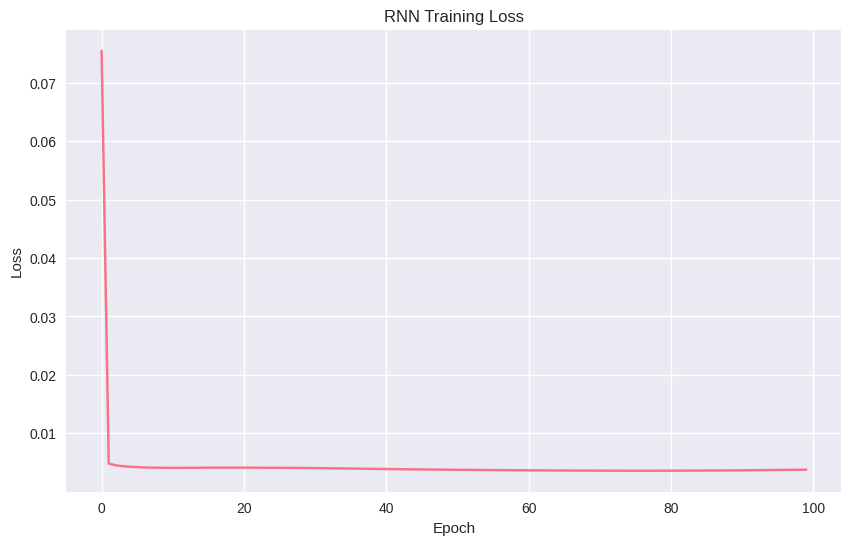

In [33]:
algo.train_rnn()

In [34]:
algo.run_backtest()

Running backtest...


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

KeyError: 'Portfolio_Value'

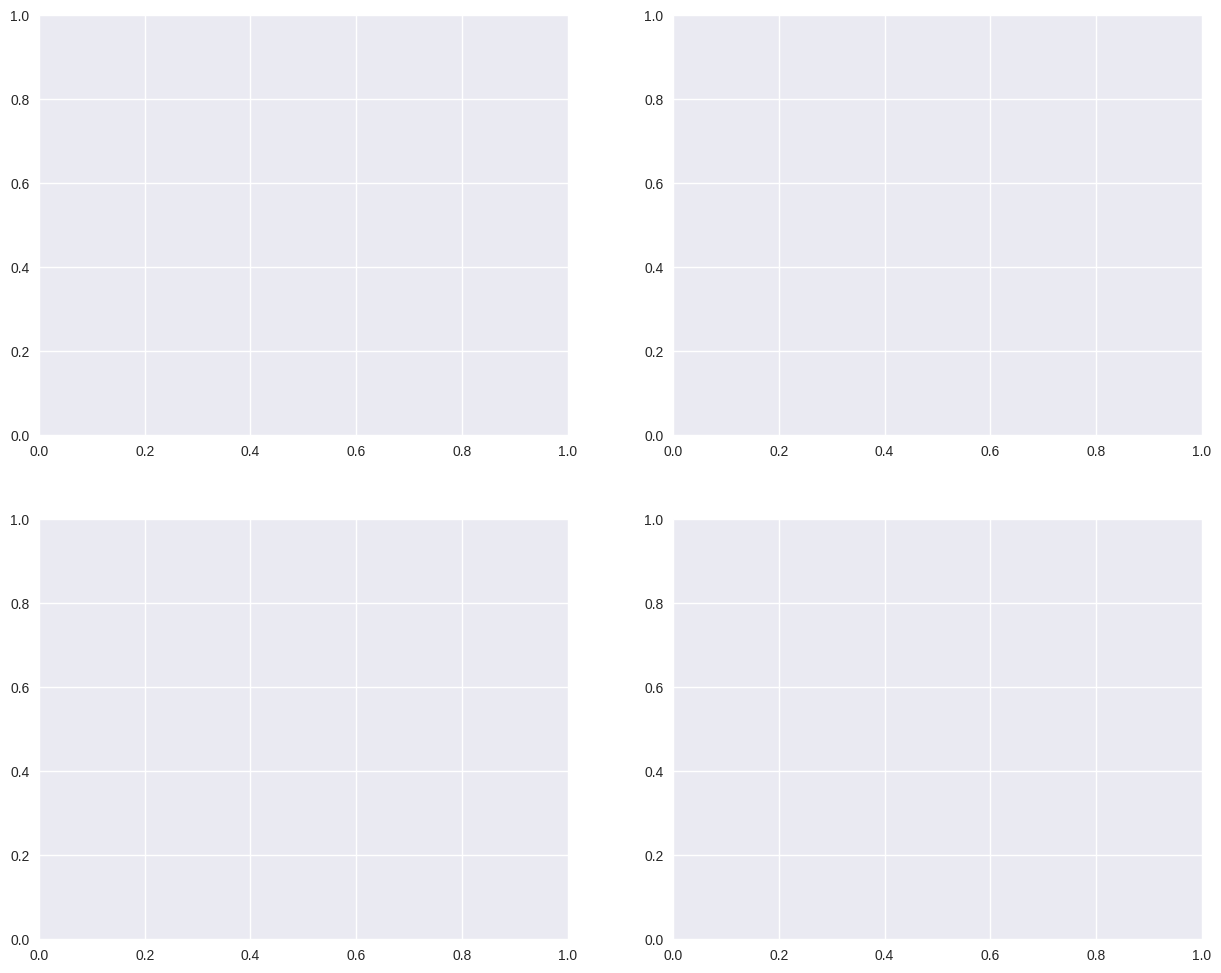

In [14]:
algo.plot_results()

In [15]:
algo.print_performance_metrics()

KeyError: 'Portfolio_Value'

In [ ]:
# Additional analysis (optional)
def additional_analysis(algo):
    """Additional analysis and visualization"""

    # Trade analysis
    if len(algo.trades) > 0:
        trades_df = pd.DataFrame(algo.trades)

        plt.figure(figsize=(12, 8))

        # Subplot 1: Trades by month
        plt.subplot(2, 2, 1)
        trades_df['month'] = trades_df['date'].dt.month
        trades_by_month = trades_df.groupby('month').size()
        trades_by_month.plot(kind='bar')
        plt.title('Trades by Month')
        plt.xlabel('Month')
        plt.ylabel('Number of Trades')

        # Subplot 2: RSI at trade times
        plt.subplot(2, 2, 2)
        buy_trades = trades_df[trades_df['action'] == 'BUY']
        sell_trades = trades_df[trades_df['action'] == 'SELL']

        plt.hist(buy_trades['rsi'], alpha=0.7, label='Buy Trades', bins=20, color='green')
        plt.hist(sell_trades['rsi'], alpha=0.7, label='Sell Trades', bins=20, color='red')
        plt.title('RSI Distribution at Trade Times')
        plt.xlabel('RSI Value')
        plt.ylabel('Frequency')
        plt.legend()

        # Subplot 3: Predictions at trade times
        plt.subplot(2, 2, 3)
        plt.hist(buy_trades['prediction'], alpha=0.7, label='Buy Trades', bins=20, color='green')
        plt.hist(sell_trades['prediction'], alpha=0.7, label='Sell Trades', bins=20, color='red')
        plt.title('RNN Predictions at Trade Times')
        plt.xlabel('Prediction Value')
        plt.ylabel('Frequency')
        plt.legend()

        # Subplot 4: Monthly returns
        plt.subplot(2, 2, 4)
        algo.data['Monthly_Return'] = algo.data['Portfolio_Value'].resample('M').last().pct_change() * 100
        monthly_returns = algo.data['Portfolio_Value'].resample('M').last().pct_change() * 100
        monthly_returns.plot(kind='bar')
        plt.title('Monthly Returns')
        plt.xlabel('Date')
        plt.ylabel('Return (%)')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Print trade statistics
        print("\nTRADE STATISTICS:")
        print(f"Average RSI at Buy: {buy_trades['rsi'].mean():.2f}")
        print(f"Average RSI at Sell: {sell_trades['rsi'].mean():.2f}")
        print(f"Average Prediction at Buy: {buy_trades['prediction'].mean():.4f}")
        print(f"Average Prediction at Sell: {sell_trades['prediction'].mean():.4f}")
